In [32]:
list.of.packages <- c("tidyverse", "data.table", "dtplyr", "arrow", "dbplyr", "duckdb", "lme4", "dbscan", "pROC", "caTools")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

library(tidyverse)
library(data.table)
#library(dtplyr)
#library(dplyr, warn.conflicts = FALSE)
library(arrow)
library(duckdb)
library(lme4)
library(dbscan)
library(pROC)
library(caTools)

Warning message in install.packages(new.packages):
"'lib = "C:/Program Files/R/R-4.4.3/library"' is not writable"


ERROR: Error in install.packages(new.packages): unable to install packages


In [2]:
raw_shots <- read_csv("../Data/NBA_Shots_Raw.csv")
player_info <- read_csv("../Data/Player_Info.csv")
player_salary <- read_csv("../Data/Player_Salary.csv")
player_info <- player_info %>% mutate(PLAYER_NAME = paste(First_Name, Surname))
player_salary <- player_salary %>% rename(PLAYER_NAME = Name)
clean_shots <- read_csv("../Data/NBA_Shots_Clean_Example.csv")

Rows: 128069 Columns: 23
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (8): DATE, HOME_TEAM, AWAY_TEAM, PLAYER_NAME, LOCATION, W, SHOT_RESULT...
dbl  (14): GAME_ID, PLAYER_ID, FINAL_MARGIN, SHOT_NUMBER, PERIOD, SHOT_CLOCK...
time  (1): GAME_CLOCK

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 475 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Birth_Place, Birthdate, College, Experience, First_Name, Pos, Surna...
dbl (5): ...1, Age, Height, Weight, BMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 513 Columns: 2
── Column specificatio

In [3]:
colnames(raw_shots)
colnames(clean_shots)
colnames(player_info)
colnames(player_salary)
#player_statistics %>% count() %>% collect()
#head(raw_shots)
#head(player_info)
#head(player_salary)


[1] "GAME_ID"             "DATE"                "HOME_TEAM"          
 [4] "AWAY_TEAM"           "PLAYER_NAME"         "PLAYER_ID"          
 [7] "LOCATION"            "W"                   "FINAL_MARGIN"       
[10] "SHOT_NUMBER"         "PERIOD"              "GAME_CLOCK"         
[13] "SHOT_CLOCK"          "DRIBBLES"            "TOUCH_TIME"         
[16] "SHOT_DIST"           "PTS_TYPE"            "SHOT_RESULT"        
[19] "CLOSEST_DEFENDER"    "CLOSEST_DEFENDER_ID" "CLOSE_DEF_DIST"     
[22] "FGM"                 "PTS"

[1] "GAME_ID"             "DATE"                "HOME_TEAM"          
 [4] "AWAY_TEAM"           "PLAYER_NAME"         "PLAYER_ID"          
 [7] "LOCATION"            "WIN_LOSE"            "FINAL_MARGIN"       
[10] "SHOT_NUMBER"         "PERIOD"              "SEC_REMAIN"         
[13] "SHOT_CLOCK"          "DRIBBLES"            "TOUCH_TIME"         
[16] "SHOT_DIST"           "PTS_TYPE"            "CLOSEST_DEFENDER"   
[19] "CLOSEST_DEFENDER_ID" "CLOSE_DEF_DIST"      "SUCCESS"

[1] "...1"        "Age"         "Birth_Place" "Birthdate"   "College"    
 [6] "Experience"  "First_Name"  "Height"      "Pos"         "Surname"    
[11] "Team"        "Weight"      "BMI"         "PLAYER_NAME"

[1] "PLAYER_NAME" "Salary"

Warning message in left_join(., player_info %>% select(Pos, PLAYER_NAME), by = "PLAYER_NAME"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 442 of `x` matches multiple rows in `y`.
ℹ Row 288 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


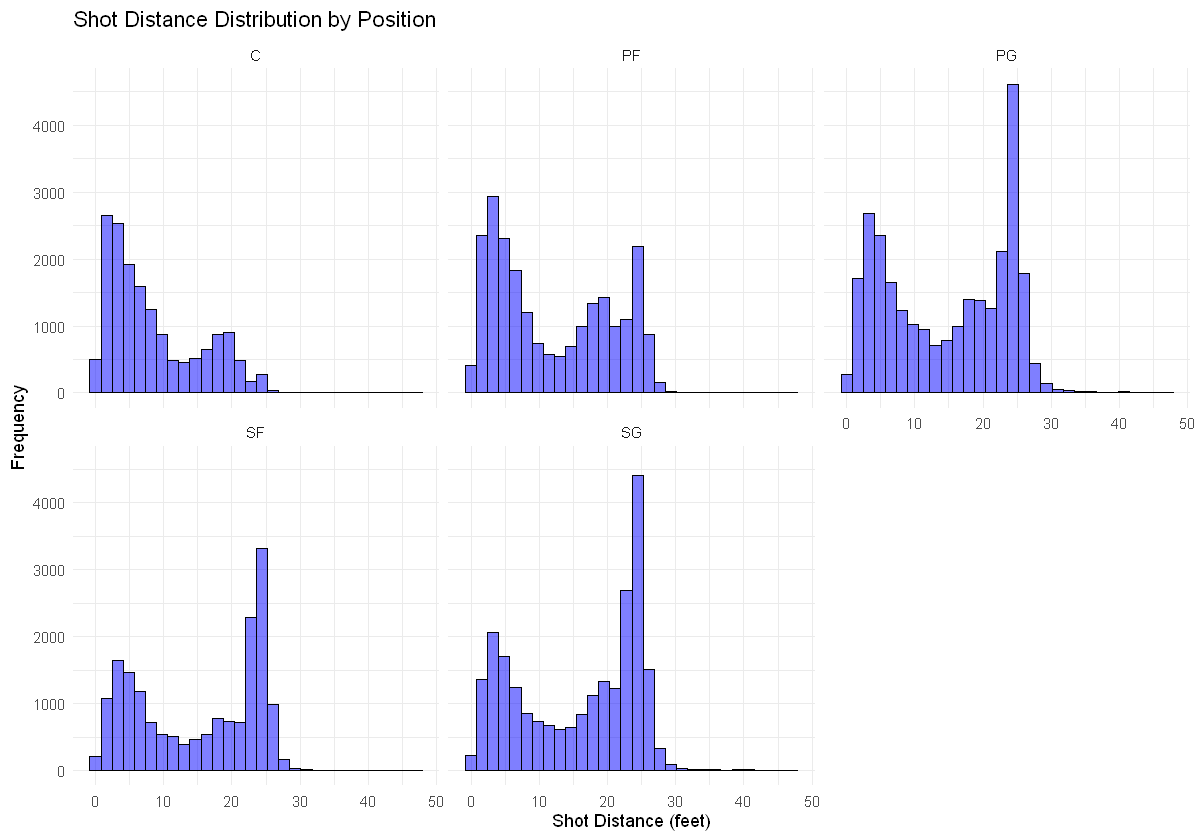

In [4]:
options(repr.plot.width = 10, repr.plot.height = 7)

s <- raw_shots %>% 
    left_join(player_info %>% select(Pos, PLAYER_NAME), by = "PLAYER_NAME") %>%
    filter(!is.na(Pos)) %>%
    select(SHOT_DIST, Pos)

ggplot(s, aes(x = SHOT_DIST)) +
    geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.5) +
    facet_wrap(~ Pos) +
    labs(title = "Shot Distance Distribution by Position",
       x = "Shot Distance (feet)",
       y = "Frequency") +
    theme_minimal()

In [5]:
l1 <- raw_shots %>%
    left_join(player_info %>% select(Pos, PLAYER_NAME), by = "PLAYER_NAME", relationship="many-to-many") %>%
    filter(!is.na(Pos)) %>%
    group_by(PLAYER_NAME, Pos) %>% 
    summarize(tot_FGM = sum(FGM), .groups="drop") %>% 
    arrange(desc(tot_FGM))
l2 <- raw_shots %>% 
    filter(FGM == 1) %>% 
    group_by(PLAYER_NAME) %>%
    summarise(
        total_FGM = n(),
        pct_3pt = sum(PTS_TYPE == 3),
        pct_2pt = sum(PTS_TYPE == 2)
    ) %>%
    left_join(player_info %>% select(Pos, PLAYER_NAME, Team, Age), by = "PLAYER_NAME", relationship="many-to-many")

In [6]:
raw_shots %>% summarise(unique_players = n_distinct(PLAYER_NAME))
player_info %>% summarise(unique_players = n_distinct(PLAYER_NAME))
player_salary %>% summarise(unique_players = n_distinct(PLAYER_NAME))

unique_players
<int>
281


unique_players
<int>
425


unique_players
<int>
513


In [7]:
#clean_shots %>% 
#    filter(PERIOD <= 3) %>%
#    select(HOME_TEAM, AWAY_TEAM, WIN_LOSE)
#    group_by(

#clean_shots %>% 
#    select(GAME_ID, FINAL_MARGIN, WIN_LOSE, HOME_TEAM, AWAY_TEAM, LOCATION) %>%
#    filter(abs(FINAL_MARGIN) <= 3) %>% #no need to filter for w/l
 #   distinct(GAME_ID, .keep_all=TRUE) %>%
#    summarise(home_win_pct = 100*sum(FINAL_MARGIN > 0 & LOCATION == "H")/sum(LOCATION == "H"))


#clean_shots %>%
#    select(GAME_ID, WIN_LOSE, HOME_TEAM, AWAY_TEAM, LOCATION, PERIOD, PTS_TYPE, SUCCESS) %>%
#    mutate(pts = PTS_TYPE * SUCCESS) %>%
#    filter(PERIOD <= 3) %>%
#    group_by(GAME_ID, LOCATION) %>%
#    summarise(total_pts = sum(pts), .groups = "drop") %>%
#    pivot_wider(names_from = LOCATION, values_from = total_pts, names_prefix = "pts_") %>%
#    summarise(pts_diff_H = pts_H-pts_A)

home_win <- clean_shots %>%
    filter(LOCATION == "H") %>%
    select(GAME_ID, HOME_TEAM, AWAY_TEAM, WIN_LOSE) %>%
    distinct(GAME_ID, .keep_all=TRUE)

clean_shots %>%
    filter(PERIOD <= 3) %>%
    mutate(pts = PTS_TYPE * SUCCESS) %>%
    group_by(GAME_ID, LOCATION) %>%
    summarise(total_pts = sum(pts), .groups = "drop") %>%
    pivot_wider(names_from = LOCATION, values_from = total_pts, names_prefix = "pts_") %>%
    left_join(home_win, by="GAME_ID") %>%
    rename(HOME_RESULT = WIN_LOSE) %>%
    mutate(pts_diff = abs(pts_H - pts_A)) %>%
    filter(pts_diff <= 3) %>%
    summarise(
        home_pct_win = sum(HOME_RESULT == "W")/n(),
        home_wins = sum(HOME_RESULT == "W"),
        total_games = n()
    )

binom.test(x=86, n=161, p=0.5, alternative="greater")

home_pct_win,home_wins,total_games
<dbl>,<int>,<int>
0.5341615,86,161



	Exact binomial test

data:  86 and 161
number of successes = 86, number of trials = 161, p-value = 0.2154
alternative hypothesis: true probability of success is greater than 0.5
95 percent confidence interval:
 0.466325 1.000000
sample estimates:
probability of success 
             0.5341615 


In [ ]:
play_by_play <- open_dataset("../Data/wyatt_basketball/csv/play_by_play.csv", format="csv")

In [ ]:
con <- DBI::dbConnect(
  duckdb::duckdb(), dbdir = ".tmp.duckdb"
)

In [ ]:
duckdb_read_csv(con, name="play_by_play", files="../Data/wyatt_basketball/csv/play_by_play.csv")

In [ ]:
colnames(tbl(con, "play_by_play") %>% head(1))

In [ ]:
tbl(con, "play_by_play") %>% count(eventmsgtype) %>% collect()
tbl(con, "play_by_play") %>% filter(eventmsgtype == 1) %>% head(10) %>% collect()

In [ ]:
dbDisconnect(con, shutdown=TRUE)

In [31]:
predictors <- c("PLAYER_NAME", "SHOT_DIST", "CLOSE_DEF_DIST", "SHOT_CLOCK", "TOUCH_TIME", "PERIOD")

model_data <- clean_shots %>% 
    select(all_of(predictors)) %>%
    left_join(player_info %>% select(PLAYER_NAME, Height), by="PLAYER_NAME", relationship = "many-to-many") %>%
    select(!PLAYER_NAME)


set.seed(0)
train_idx <- sample(1:nrow(clean_shots_scaled), 0.7 * nrow(clean_shots_scaled))
train_data <- clean_shots_scaled[train_idx, ]
test_data <- clean_shots_scaled[-train_idx, ]



SHOT_DIST,CLOSE_DEF_DIST,SHOT_CLOCK,TOUCH_TIME,PERIOD,Height
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.6,1.7,11.3,0.8,1,210
0.9,2.0,13.0,2.9,1,210
0.8,2.6,11.5,0.6,1,210
3.4,1.5,21.6,0.6,1,210
2.6,4.5,15.9,0.8,1,210
2.7,1.7,24.0,1.1,1,210
1.2,3.6,22.6,0.3,2,210
2.3,2.1,23.1,2.0,2,210
3.6,2.2,8.4,6.5,3,210


In [ ]:
log_model <- glm(SUCCESS ~ SHOT_DIST + CLOSE_DEF_DIST + SHOT_CLOCK + TOUCH_TIME, data=clean_shots, family="binomial")
log_mm_model <- glmer(SUCCESS ~ SHOT_DIST + CLOSE_DEF_DIST + SHOT_CLOCK + TOUCH_TIME + PERIOD +
                      (SHOT_DIST | PLAYER_ID),
                    data = train_data,
                    family=binomial(link = "logit"))

summary(log_mm_model)
test_data$pred_prob <- predict(log_mm_model, type = "response", newdata=test_data)
roc(SUCCESS ~ pred_prob, data = test_data)

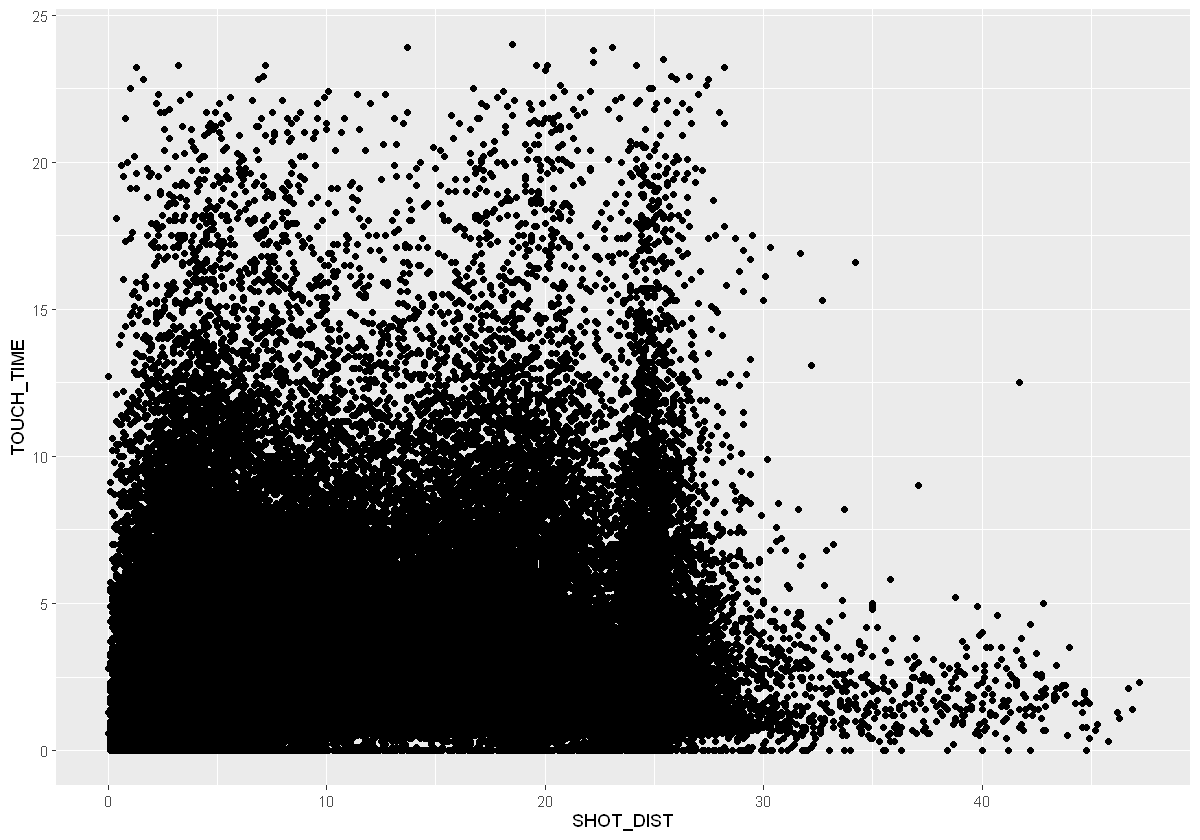

In [8]:
ggplot(clean_shots, aes(x=SHOT_DIST, y=TOUCH_TIME)) + 
    geom_point()